<a href="https://colab.research.google.com/github/ziatdinovmax/atomai/blob/master/examples/notebooks/atomai_atomnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to train a (fully convolutional) neural network and make predictions on experimental data

Prepared by Maxim Ziatdinov

E-mail: maxim.ziatdinov@ai4microscopy.com

## Install AtomAI

Install AtomAI:

In [1]:
!pip install git+https://github.com/ziatdinovmax/atomai --upgrade

  Cloning https://github.com/ziatdinovmax/atomai to /tmp/pip-req-build-fv9ujf8w
  Running command git clone -q https://github.com/ziatdinovmax/atomai /tmp/pip-req-build-fv9ujf8w
  Created wheel for atomai: filename=atomai-0.5.0-cp36-none-any.whl size=66217 sha256=5a714c460430cc4f672f233a7ffc2a2072404b5f578dee230ed34cf57cccd632
  Stored in directory: /tmp/pip-ephem-wheel-cache-5zukqkbe/wheels/49/47/01/932ce6186e3f5af7f35fd44f2adffc226972afec7027d43ff6
Successfully built atomai
  Found existing installation: atomai 0.5.0
    Uninstalling atomai-0.5.0:
      Successfully uninstalled atomai-0.5.0


Import modules:

In [1]:
import atomai as aoi
import numpy as np

## Single-class model

We start by (down)loading the training data, which is based on a single labeled experimental STEM image of Sm-doped BFO containing ~20,000 atomic unit cells (see *arXiv:2002.04245* and the associated notebook). The original image was ~3000 px x 3000 px. We randomly cropped about 2000 image-label pairs of 256 x 256 resolution and then applied different image "distortions" (noise, blurring, zoom, etc.) to each cropped image, treating all atoms as one class. Because the training data are just numpy arrays you can easily vizualize it with standard matplotlib functions. You can pass the training/test images and labels as 4 separate numpy arrays with the dimensions ```(n_images, n_channels=1, image_height, image_width)``` for training images, ```(n_images, n_channels=1, image_height, image_width)``` for labels with only one class of atoms (or all atoms treated as one class) and ```(n_images, image_height, image_width)``` for labels with multiple classes. YOu can also pass your data as 4 separate python lists (or dictionaries) where each element in a list (or value in a dictionary) is a small numpy array (typically containing from 8 to 32 images). Notice that even if you forget to add a pseudo-channel of 1 to your data, AtomAI will do it for you (and display a warning). After training a model, we will apply it to an experimental image from a different experiment/system (La-doped BFO) to see if it can find atoms in that previously unseen data. 

In [3]:
download_link = 'https://drive.google.com/uc?id=1-0fXGXGY8jW11q2GdPZ2hmOhQ7-WNlnK'
#!gdown -q $download_link -O 'training_data.npy'
dataset_1 = np.load('training_data.npy')
images_1 = dataset_1['X_train']
labels_1 = dataset_1['y_train']
images_test_1 = dataset_1['X_test']
labels_test_1 = dataset_1['y_test']
print(images_1.shape, labels_1.shape)

(1600, 1, 256, 256) (1600, 1, 256, 256)


After loading training data we can go straight to model training. This is because we believe that we already found an optimal neural network architecture for atom/defect finding ( see e.g. *Applied Physics Letters 115, 052902 (2019)*, *Advanced Functional Materials 29, 1904480 (2019)* ) and because we also found that the small improvements in the accuracy on the standard datasets like ImageNet due to the tweaks to the network's architecture are somewhat meaningless for the noisy experimental data as they usually are within the "error bar".

The model training is esentially one line of code. The final model weights will be saved automatically (by default they will be saved to the root directory, but you can change that).

Epoch 1 ... Training loss: 0.7418 ... Test loss: 0.7449 ... Train IoU: 0.2795 ... Test IoU: 0.114 ... GPU memory usage: 4479/16280
Epoch 100 ... Training loss: 0.3563 ... Test loss: 0.3266 ... Train IoU: 0.736 ... Test IoU: 0.7566 ... GPU memory usage: 4479/16280
Epoch 200 ... Training loss: 0.2378 ... Test loss: 0.2349 ... Train IoU: 0.7867 ... Test IoU: 0.7523 ... GPU memory usage: 4479/16280
Epoch 300 ... Training loss: 0.2339 ... Test loss: 0.2229 ... Train IoU: 0.7725 ... Test IoU: 0.7787 ... GPU memory usage: 4479/16280
Epoch 400 ... Training loss: 0.2056 ... Test loss: 0.2009 ... Train IoU: 0.7825 ... Test IoU: 0.766 ... GPU memory usage: 4479/16280
Epoch 500 ... Training loss: 0.2313 ... Test loss: 0.2198 ... Train IoU: 0.7766 ... Test IoU: 0.7749 ... GPU memory usage: 4479/16280
Model (final state) evaluation loss: 0.2288
Model (final state) IoU: 0.7657
Plotting training history


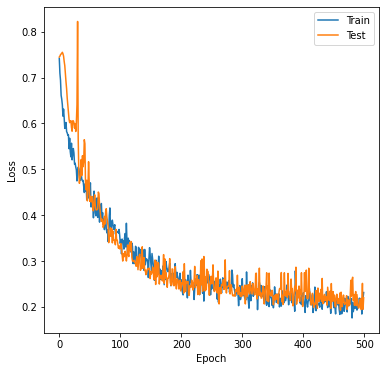

In [4]:
trained_model_1 = aoi.atomnet.train_single_model(images_1, labels_1,
                                                 images_test_1, labels_test_1,
                                                 training_cycles=500, IoU=True)

Now let's make a prediction on the image from a different experiment ( the data is from our paper in *Applied Physics Letters 115, 052902 (2019)* ). Notice that ```atomnet.predictor``` also returns the actual image that was fed into a neural network, which sometimes may not be identical to the image that was loaded (e.g. if an extra padding is needed or if we choose to resize it).

In [5]:
# Load "validation" data
expdata = dataset_1['validation_img']
# Get NN output with atomic coordinates
predictive = aoi.atomnet.predictor(trained_model_1, refine=False, use_gpu=True)
nn_input, (nn_output, coordinates_1) = predictive.run(expdata)

Batch 1/1
1 image was decoded in approximately 0.1228 seconds


Plot results:

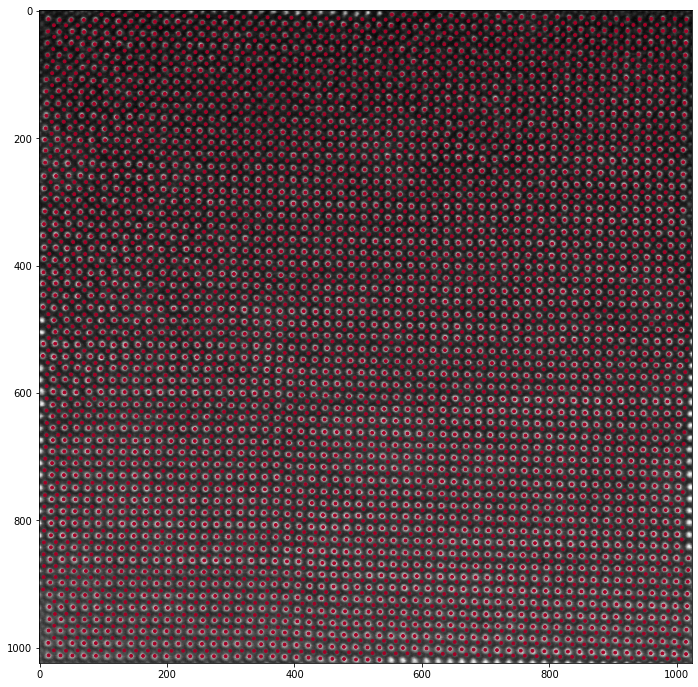

In [6]:
aoi.utils.plot_coord(expdata, coordinates_1[0], fsize=12)

Looks like our model performed quite well on the previously unseen data and found some interesting local atomic distortions! There is no ground truth for the experimental data, so evaluating accuracy is somewhat tricky. Notice that it is always a good idea to train your model on a diverse training set (e.g. many labeled expermental images, or simulated data for variety of atomic structures/positions). Here we used a training set made from a single image just to show a *quick* example of how atomnet module works. Such a model will not generalize very well.

Before training a multi-class model we show that it is possible to update predictions of a single model by splitting them into different classes of atoms (or defects) with a simple statistical analysis (more on the usage of ```atomstat``` module in this [notebook](https://colab.research.google.com/github/ziatdinovmax/atomai/blob/master/examples/notebooks/atomai_atomstat.ipynb). First, we collect intensities around the detected centers and then apply a meanshift clustering algorithms to the "feature vector" of intensities:

In [17]:
updated_coordinates_1 = aoi.atomstat.update_classes(coordinates_1, nn_input,
                                                    method="meanshift", q=.1)

PLot the results:

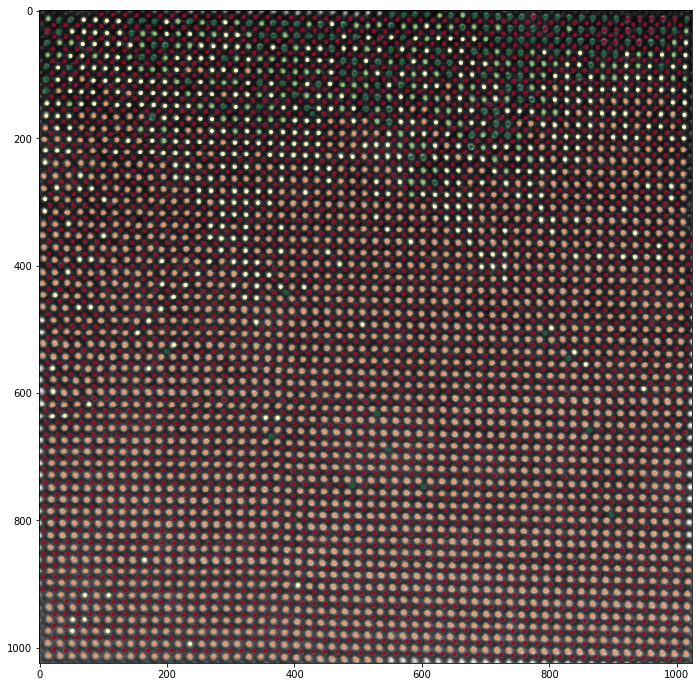

In [18]:
aoi.utils.plot_coord(expdata, updated_coordinates_1[0], fsize=12)

The method was able to separate two distinct sublattices in most parts of the image but got confused by a sample thickness variation which were categorized in a separate class.

Now let's try to use surrounding of each atom to construct our "feature vector" and then apply Gaussian mixture model to it:

/usr/local/lib/python3.6/dist-packages/atomai/atomstat/multivar.py:94: UserWarning: The crop_size argument is deprecated. Use window_size to specify size of subimages
  UserWarning)



GMM components


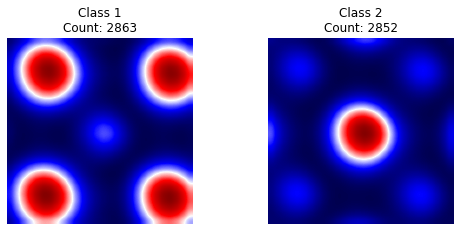

In [19]:
updated_coordinates_1 = aoi.atomstat.update_classes(
    coordinates_1, nn_input, method="gmm_local",
    window_size=28, n_components=2)

Plot the results:

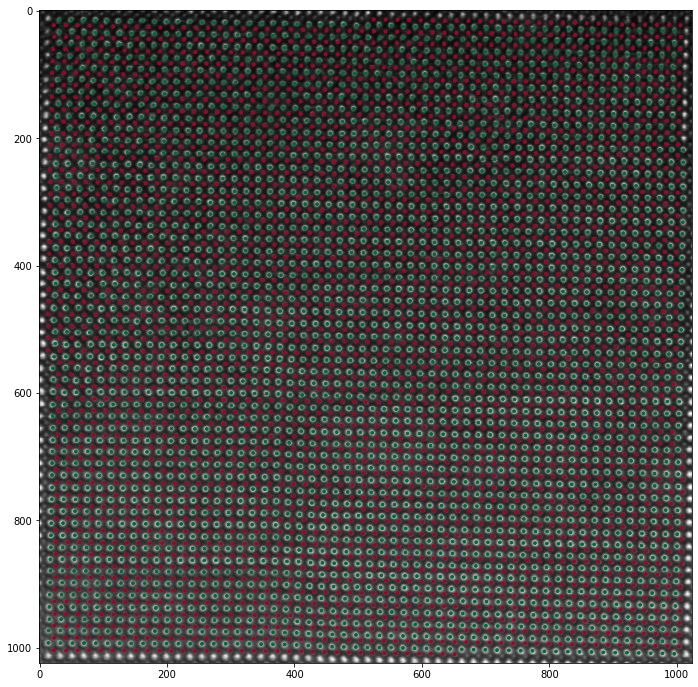

In [20]:
aoi.utils.plot_coord(expdata, updated_coordinates_1[0], fsize=12)

Looks like we were able to separate the predicted atoms into two sublattices, even though the inital neural network was trained to categorize all the atoms as one class.

## Multi-class model

We now repeat the same routines but for the training data where different atomic elements correspond to different classes (the experimental image used for generation of this training data is the same as for the single-class case). The structure of the training data is similar to what we had in the single-class case (notice, however, that the labels are now a 3D array, without a channel dimension) and also can be easily vizualized with matplotlib.

(Down)load data:

In [21]:
download_link = 'https://drive.google.com/uc?id=1-4-IQ71m--OelQb1891GnbG1Ako1-DKh'
!gdown -q $download_link -O 'training_data-m.npy'
dataset_2 = np.load('training_data-m.npy')
images_2 = dataset_2['X_train']
labels_2 = dataset_2['y_train']
images_test_2 = dataset_2['X_test']
labels_test_2 = dataset_2['y_test']
print(images_2.shape, labels_2.shape)

(1656, 1, 256, 256) (1656, 256, 256)


Train a model:

Epoch 1 ... Training loss: 1.2691 ... Test loss: 1.2116 ... Train IoU: 0.0863 ... Test IoU: 0.0405 ... GPU memory usage: 5091/16280
Epoch 100 ... Training loss: 0.4471 ... Test loss: 0.4202 ... Train IoU: 0.6769 ... Test IoU: 0.6492 ... GPU memory usage: 5091/16280
Epoch 200 ... Training loss: 0.2755 ... Test loss: 0.2529 ... Train IoU: 0.7304 ... Test IoU: 0.7484 ... GPU memory usage: 5091/16280
Epoch 300 ... Training loss: 0.2337 ... Test loss: 0.2284 ... Train IoU: 0.7438 ... Test IoU: 0.7441 ... GPU memory usage: 5091/16280
Epoch 400 ... Training loss: 0.2027 ... Test loss: 0.2287 ... Train IoU: 0.7628 ... Test IoU: 0.7271 ... GPU memory usage: 5091/16280
Epoch 500 ... Training loss: 0.193 ... Test loss: 0.2023 ... Train IoU: 0.7738 ... Test IoU: 0.7561 ... GPU memory usage: 5091/16280
Model (final state) evaluation loss: 0.206
Model (final state) IoU: 0.7514
Plotting training history


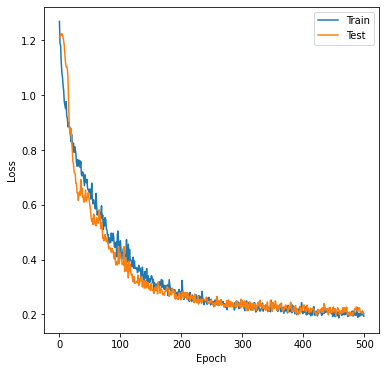

In [22]:
trained_model_2 = aoi.atomnet.train_single_model(images_2, labels_2,
                                                 images_test_2, labels_test_2,
                                                 training_cycles=500, IoU=True)

Get a prediction on the same image as in the single-class case:

In [23]:
# Get NN output with atomic cooridnates and classes
predictive = aoi.atomnet.predictor(trained_model_2, refine=False, use_gpu=True)
nn_input, (nn_output, coordinates_2) = predictive.run(expdata)

Batch 1/1
1 image was decoded in approximately 0.1704 seconds


Plot results:

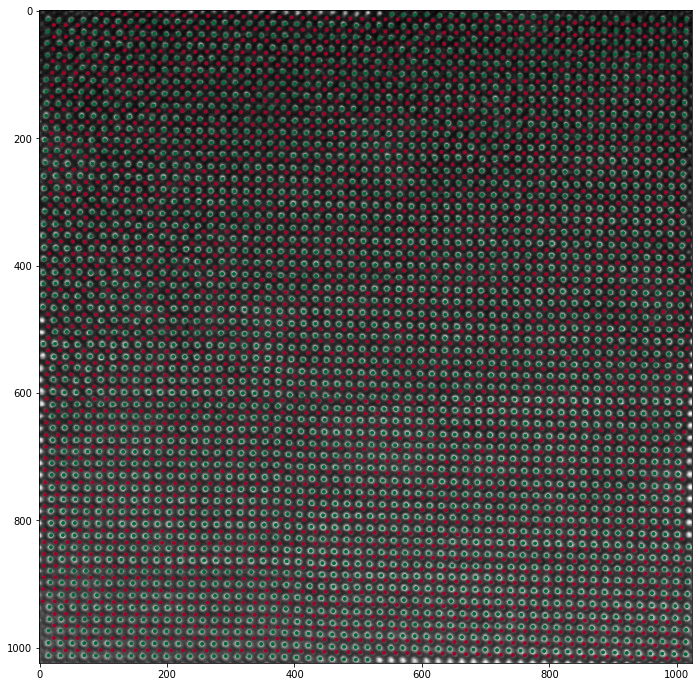

In [24]:
aoi.utils.plot_coord(expdata, coordinates_2[0], fsize=12)

Our model can now distinguish between two different sublattices. This was achieved by changing the training set, while the deep learning model architecture remained the same. Notice that it seems like our some model misclassified some atoms in certain areas. It is worth noting that the sample is doped, which wasn't take into account in our training set. Therefore, there may be some "misclassification" due to the doping.